In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import replace
from pathlib import Path

from fastdist import fastdist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import pdist
from sklearn.metrics import average_precision_score
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory, flatten_trajectory

In [4]:
dataset = "librispeech-train-clean-100"
state_space_name = "word"

# base_model = "w2v2_6"
# model_class = "rnn_8-weightdecay0.01"
# model_name = "biphone_recon"

base_model = "w2v2_8"
model_class = "rnn_32-aniso3"
model_name = "word_broad"

model_dir = f"outputs/models/{dataset}/{base_model}/{model_class}/{model_name}_10frames"
output_dir = f"outputs/notebooks/{dataset}/{base_model}/{model_class}/{model_name}_10frames/state_space"
dataset_path = f"outputs/preprocessed_data/{dataset}"
equivalence_path = f"outputs/equivalence_datasets/{dataset}/{base_model}/{model_name}_10frames/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{dataset}/{base_model}/hidden_states.h5"
state_space_specs_path = f"outputs/state_space_specs/{dataset}/{base_model}/state_space_specs.pkl"
embeddings_path = f"outputs/model_embeddings/{dataset}/{base_model}/{model_class}/{model_name}_10frames/{dataset}.npy"

metric = "cosine"

agg_methods = ["mean", "max", "last_frame"]

# Keep just the K most frequent words
k = 500

# Keep at most N instances of each word
n = 50

In [5]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
with open(state_space_specs_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = torch.load(f)[state_space_name]
assert state_space_spec.is_compatible_with(model_representations)

In [7]:
# keep the K most frequent words
state_space_spec_small = state_space_spec.keep_top_k(k)
# keep at most N instances per word
state_space_spec_small = state_space_spec_small.subsample_instances(n, random=True)

In [8]:
trajectory = prepare_state_trajectory(
    model_representations,
    state_space_spec_small,
    pad=np.nan
)

In [9]:
trajectory = aggregate_state_trajectory(trajectory, state_space_spec_small, "mean", keepdims=True)
flat_traj, flat_traj_src = flatten_trajectory(trajectory)

Aggregating:   0%|          | 0/500 [00:00<?, ?label/s]

In [20]:
flat_traj = (flat_traj - flat_traj.mean(axis=0)) / flat_traj.std(axis=0)

In [21]:
flat_traj.shape

(25000, 32)

In [22]:
# dists = pdist(flat_traj, metric)
dists = fastdist.matrix_pairwise_distance(flat_traj, getattr(fastdist, metric), metric)

In [13]:
labels = 1 - np.minimum(1., pdist(flat_traj_src[:, :1], metric="euclidean")).astype(int)

In [18]:
ap = average_precision_score(labels, dists)
ap

0.02217128975521502

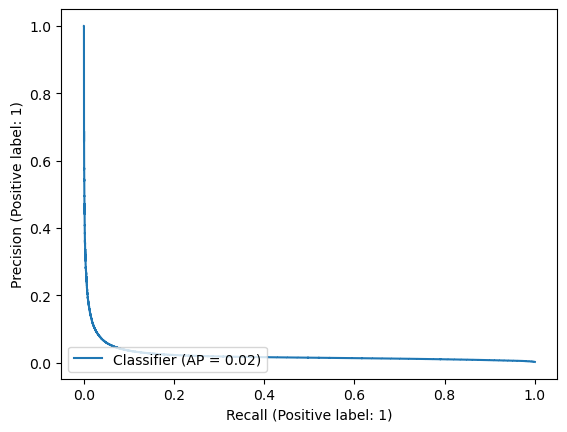

In [19]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(labels, dists)